# Preparation

In [116]:
from main import *
from helpers import *
from ds import *

import pandas as pd

In [2]:
if torch.cuda.is_available():
    print("using cuda!")
    device = "cuda:0"
else:
    print("using cpu.")
    device = "cpu"
print(device)

using cuda!
cuda:0


In [54]:
# load dataset and label map
name = "segments/sidewalk-semantic"
train_ds, test_ds = make_dataset(name)
id2label = get_label_map(name)
print(id2label)

Found cached dataset parquet (C:/Users/dario/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-1680095ec7b2b03f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 34.45it/s]
Loading cached shuffled indices for dataset at C:\Users\dario\.cache\huggingface\datasets\segments___parquet\segments--sidewalk-semantic-2-1680095ec7b2b03f\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-dc5e003bf815860f.arrow


{0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


In [130]:
# by passing the custom label dictionary, the classification head is replaced!
processor, model = load_model(models[0]["huggingface_id"], id2label = id2label)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([36, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([36]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([36]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# creating and checking batches
train_dataloader, test_dataloader = create_batch(train_ds, test_ds, 2, processor)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 384, 384])
pixel_mask torch.Size([2, 384, 384])
mask_labels torch.Size([8, 384, 384])
class_labels torch.Size([8])
original_images (1080, 1920, 3)
original_segmentation_maps (1080, 1920)


In [6]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels', 'original_images', 'original_segmentation_maps'])

(3, 384, 384)


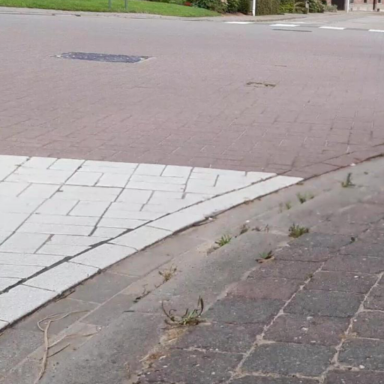

In [7]:
# verifying dataset
image = batch["pixel_values"][0].numpy()
print(image.shape)
unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

# Training

In [7]:
# checking initial performance...
metric = evaluate.load("mean_iou")
metric = eval_model(model, test_dataloader, processor, device, metric)
print(f"Mean IoU: {metric.compute(num_labels = len(id2label), ignore_index=0)['mean_iou']}")

model setup: 0.17566680908203125 seconds


  0%|          | 0/100 [00:00<?, ?it/s]

forward pass time: 2.1197519302368164 seconds
image loading time: 0.001001119613647461 seconds
image processing time: 0.008006811141967773 seconds


  1%|          | 1/100 [00:16<27:29, 16.66s/it]

evaluation time: 14.368762493133545 seconds
forward pass time: 0.15259718894958496 seconds
image loading time: 0.0010013580322265625 seconds
image processing time: 0.001001119613647461 seconds


  2%|▏         | 2/100 [00:31<25:22, 15.54s/it]

evaluation time: 14.447500467300415 seconds
forward pass time: 0.27484965324401855 seconds
image loading time: 0.0010006427764892578 seconds
image processing time: 0.0010006427764892578 seconds


  3%|▎         | 3/100 [00:46<24:34, 15.20s/it]

evaluation time: 14.351885795593262 seconds
forward pass time: 0.16715192794799805 seconds
image loading time: 0.0 seconds
image processing time: 0.001001119613647461 seconds


  4%|▍         | 4/100 [01:01<24:03, 15.04s/it]

evaluation time: 14.471076488494873 seconds
forward pass time: 0.17616963386535645 seconds
image loading time: 0.0010008811950683594 seconds
image processing time: 0.0010004043579101562 seconds


  5%|▌         | 5/100 [01:15<23:36, 14.91s/it]

evaluation time: 14.335264921188354 seconds
forward pass time: 0.39359307289123535 seconds
image loading time: 0.001001119613647461 seconds
image processing time: 0.0010008811950683594 seconds


  6%|▌         | 6/100 [01:30<23:24, 14.94s/it]

evaluation time: 14.45456314086914 seconds
forward pass time: 0.17207860946655273 seconds
image loading time: 0.0014960765838623047 seconds
image processing time: 0.0005066394805908203 seconds


  7%|▋         | 7/100 [01:45<23:03, 14.87s/it]

evaluation time: 14.405080556869507 seconds
forward pass time: 0.16314077377319336 seconds
image loading time: 0.001001596450805664 seconds
image processing time: 0.0 seconds


  8%|▊         | 8/100 [02:00<22:44, 14.84s/it]

evaluation time: 14.431495666503906 seconds
forward pass time: 0.15783476829528809 seconds
image loading time: 0.0010008811950683594 seconds
image processing time: 0.001001119613647461 seconds


  9%|▉         | 9/100 [02:14<22:29, 14.83s/it]

evaluation time: 14.494723081588745 seconds
forward pass time: 0.33466410636901855 seconds
image loading time: 0.001001119613647461 seconds
image processing time: 0.0010013580322265625 seconds


 10%|█         | 10/100 [02:29<22:19, 14.88s/it]

evaluation time: 14.501598358154297 seconds
forward pass time: 0.16667747497558594 seconds
image loading time: 0.001001119613647461 seconds
image processing time: 0.0010013580322265625 seconds


 11%|█         | 11/100 [02:44<21:59, 14.83s/it]

evaluation time: 14.380610942840576 seconds
forward pass time: 0.16363191604614258 seconds
image loading time: 0.001001119613647461 seconds
image processing time: 0.001001119613647461 seconds


 11%|█         | 11/100 [02:50<22:56, 15.47s/it]


KeyboardInterrupt: 

In [56]:
# tuning! ~5 minutes per epoch...
n_epochs = 20
finetuned_model = train_model(model.to(device), train_dataloader, test_dataloader, processor, device, epochs = n_epochs)
finetuned_model.save_pretrained(f"mask2former_finetuned_{name.replace('/','-')}_{n_epochs}epochs")

Epoch: 0


  0%|          | 1/400 [00:01<06:39,  1.00s/it]


Loss: 51.50468444824219


 25%|██▌       | 101/400 [02:07<09:20,  1.88s/it]


Loss: 31.472673453906975


 50%|█████     | 201/400 [05:10<05:45,  1.73s/it]


Loss: 28.470666671866802


 75%|███████▌  | 301/400 [08:06<03:01,  1.84s/it]


Loss: 26.904523713248118


100%|██████████| 400/400 [11:08<00:00,  1.67s/it]


Epoch: 1


  0%|          | 1/400 [00:02<14:17,  2.15s/it]


Loss: 25.851826061334396


 25%|██▌       | 101/400 [03:06<09:03,  1.82s/it]


Loss: 25.066654709760776


 50%|█████     | 201/400 [06:10<06:08,  1.85s/it]


Loss: 24.49933306429033


 75%|███████▌  | 301/400 [09:15<03:01,  1.83s/it]


Loss: 23.93294903895314


100%|██████████| 400/400 [12:16<00:00,  1.84s/it]


Epoch: 2


  0%|          | 1/400 [00:02<13:55,  2.09s/it]


Loss: 23.49952967187736


 25%|██▌       | 101/400 [03:06<09:15,  1.86s/it]


Loss: 23.179929506765486


 50%|█████     | 201/400 [06:08<05:58,  1.80s/it]


Loss: 22.781545586638398


 75%|███████▌  | 301/400 [09:12<02:58,  1.80s/it]


Loss: 22.427815075249807


100%|██████████| 400/400 [12:14<00:00,  1.84s/it]


Epoch: 3


  0%|          | 1/400 [00:02<14:18,  2.15s/it]


Loss: 22.161979486305054


 25%|██▌       | 101/400 [03:05<09:05,  1.82s/it]


Loss: 21.851955631528792


 50%|█████     | 201/400 [06:08<05:58,  1.80s/it]


Loss: 21.63054728933439


 75%|███████▌  | 301/400 [09:12<03:03,  1.85s/it]


Loss: 21.39918060417099


100%|██████████| 400/400 [12:13<00:00,  1.83s/it]


Epoch: 4


  0%|          | 1/400 [00:02<13:35,  2.04s/it]


Loss: 21.173532095795345


 25%|██▌       | 101/400 [03:05<09:03,  1.82s/it]


Loss: 21.005621594446396


 50%|█████     | 201/400 [06:09<06:07,  1.84s/it]


Loss: 20.801946793841626


 75%|███████▌  | 301/400 [09:13<03:06,  1.88s/it]


Loss: 20.627324234743234


100%|██████████| 400/400 [12:13<00:00,  1.83s/it]


Epoch: 5


  0%|          | 1/400 [00:02<14:02,  2.11s/it]


Loss: 20.405365988708983


 25%|██▌       | 101/400 [03:05<09:02,  1.81s/it]


Loss: 20.249335221822122


 50%|█████     | 201/400 [06:09<06:04,  1.83s/it]


Loss: 20.130425471167626


 75%|███████▌  | 301/400 [09:12<02:58,  1.80s/it]


Loss: 19.987507813705253


100%|██████████| 400/400 [12:13<00:00,  1.83s/it]


Epoch: 6


  0%|          | 1/400 [00:02<13:49,  2.08s/it]


Loss: 19.828477880747204


 25%|██▌       | 101/400 [03:05<09:06,  1.83s/it]


Loss: 19.68552119748109


 50%|█████     | 201/400 [06:08<05:57,  1.79s/it]


Loss: 19.55020076373319


 75%|███████▌  | 301/400 [09:12<02:59,  1.81s/it]


Loss: 19.437654988494725


100%|██████████| 400/400 [12:13<00:00,  1.83s/it]


Epoch: 7


  0%|          | 1/400 [00:02<14:08,  2.13s/it]


Loss: 19.327216463146872


 25%|██▌       | 101/400 [03:05<09:03,  1.82s/it]


Loss: 19.22699068694721


 50%|█████     | 201/400 [06:09<06:02,  1.82s/it]


Loss: 19.109859039925688


 75%|███████▌  | 301/400 [09:12<03:03,  1.85s/it]


Loss: 19.031717079295454


100%|██████████| 400/400 [12:13<00:00,  1.83s/it]


Epoch: 8


  0%|          | 1/400 [00:02<13:31,  2.03s/it]


Loss: 18.943926210591137


 25%|██▌       | 101/400 [03:05<08:56,  1.79s/it]


Loss: 18.838919532114865


 50%|█████     | 201/400 [06:09<06:06,  1.84s/it]


Loss: 18.750863491665157


 75%|███████▌  | 301/400 [09:12<03:00,  1.82s/it]


Loss: 18.66705244699569


100%|██████████| 400/400 [12:14<00:00,  1.84s/it]


Epoch: 9


  0%|          | 1/400 [00:02<13:31,  2.03s/it]


Loss: 18.593771902993797


 25%|██▌       | 101/400 [03:10<09:07,  1.83s/it]


Loss: 18.513527226299892


 50%|█████     | 201/400 [06:00<05:00,  1.51s/it]


Loss: 18.427220968973067


 75%|███████▌  | 301/400 [07:45<01:10,  1.41it/s]


Loss: 18.345822626246882


100%|██████████| 400/400 [10:42<00:00,  1.61s/it]


Epoch: 10


  0%|          | 1/400 [00:02<16:30,  2.48s/it]


Loss: 18.2751281709559


 25%|██▌       | 101/400 [03:13<09:17,  1.86s/it]


Loss: 18.19859377676846


 50%|█████     | 201/400 [06:12<06:13,  1.88s/it]


Loss: 18.130406767037673


 75%|███████▌  | 301/400 [09:16<03:07,  1.90s/it]


Loss: 18.066410526401135


100%|██████████| 400/400 [12:04<00:00,  1.81s/it]


Epoch: 11


  0%|          | 1/400 [00:02<14:23,  2.16s/it]


Loss: 18.01110899342756


 25%|██▌       | 101/400 [03:01<09:45,  1.96s/it]


Loss: 17.945336101638347


 50%|█████     | 201/400 [06:06<06:06,  1.84s/it]


Loss: 17.88038033455565


 75%|███████▌  | 301/400 [09:11<02:07,  1.29s/it]


Loss: 17.816552278666364


100%|██████████| 400/400 [12:07<00:00,  1.82s/it]


Epoch: 12


  0%|          | 1/400 [00:00<04:48,  1.39it/s]


Loss: 17.759033946140786


 25%|██▌       | 101/400 [01:07<03:16,  1.52it/s]


Loss: 17.702656961805697


 50%|█████     | 201/400 [02:14<02:14,  1.48it/s]


Loss: 17.639901643084468


 75%|███████▌  | 301/400 [03:21<01:04,  1.54it/s]


Loss: 17.55945852428669


100%|██████████| 400/400 [04:28<00:00,  1.49it/s]


Epoch: 13


  0%|          | 1/400 [00:00<04:33,  1.46it/s]


Loss: 17.508006715426145


 25%|██▌       | 101/400 [01:08<03:24,  1.46it/s]


Loss: 17.444546890177833


 50%|█████     | 201/400 [02:16<02:16,  1.46it/s]


Loss: 17.379595310108417


 75%|███████▌  | 301/400 [03:26<01:07,  1.47it/s]


Loss: 17.34145664969394


100%|██████████| 400/400 [04:33<00:00,  1.46it/s]


Epoch: 14


  0%|          | 1/400 [00:00<04:29,  1.48it/s]


Loss: 17.298501767509432


 25%|██▌       | 101/400 [01:11<03:28,  1.43it/s]


Loss: 17.24784929642362


 50%|█████     | 201/400 [02:21<02:14,  1.48it/s]


Loss: 17.19246929457549


 75%|███████▌  | 301/400 [03:29<01:07,  1.48it/s]


Loss: 17.158683683564757


100%|██████████| 400/400 [04:37<00:00,  1.44it/s]


Epoch: 15


  0%|          | 1/400 [00:00<04:25,  1.50it/s]


Loss: 17.10834587126886


 25%|██▌       | 101/400 [01:09<03:27,  1.44it/s]


Loss: 17.055936079575496


 50%|█████     | 201/400 [02:18<02:18,  1.44it/s]


Loss: 17.0016044411923


 75%|███████▌  | 301/400 [03:26<01:07,  1.46it/s]


Loss: 16.963864269152158


100%|██████████| 400/400 [04:35<00:00,  1.45it/s]


Epoch: 16


  0%|          | 1/400 [00:00<04:40,  1.42it/s]


Loss: 16.923670217145737


 25%|██▌       | 101/400 [01:11<03:44,  1.33it/s]


Loss: 16.892999706149485


 50%|█████     | 201/400 [02:23<02:19,  1.42it/s]


Loss: 16.856565701602136


 75%|███████▌  | 301/400 [03:33<01:11,  1.38it/s]


Loss: 16.81052447094737


100%|██████████| 400/400 [04:43<00:00,  1.41it/s]


Epoch: 17


  0%|          | 1/400 [00:00<06:06,  1.09it/s]


Loss: 16.764421534036963


 25%|██▌       | 101/400 [01:11<03:34,  1.40it/s]


Loss: 16.723450214063718


 50%|█████     | 201/400 [02:21<02:18,  1.44it/s]


Loss: 16.682628015606188


 75%|███████▌  | 301/400 [03:31<01:15,  1.32it/s]


Loss: 16.6394859403141


100%|██████████| 400/400 [04:38<00:00,  1.43it/s]


Epoch: 18


  0%|          | 1/400 [00:00<04:21,  1.53it/s]


Loss: 16.601156654100983


 25%|██▌       | 101/400 [01:22<03:14,  1.54it/s]


Loss: 16.55451761368382


 50%|█████     | 201/400 [02:30<02:19,  1.42it/s]


Loss: 16.51250137633334


 75%|███████▌  | 301/400 [03:39<01:08,  1.44it/s]


Loss: 16.477906530053755


100%|██████████| 400/400 [04:45<00:00,  1.40it/s]


Epoch: 19


  0%|          | 1/400 [00:00<04:34,  1.45it/s]


Loss: 16.43627272805263


 25%|██▌       | 101/400 [01:07<03:14,  1.54it/s]


Loss: 16.39156792074376


 50%|█████     | 201/400 [02:13<02:13,  1.49it/s]


Loss: 16.359546873695102


 75%|███████▌  | 301/400 [03:20<01:04,  1.53it/s]


Loss: 16.31529954623126


100%|██████████| 400/400 [04:27<00:00,  1.50it/s]


In [57]:
# evaluation of finetuned model!
eval_model(finetuned_model, test_dataloader, processor, device, 5)

100%|██████████| 100/100 [23:57<00:00, 14.38s/it]

total time: 1438.7113590240479 seconds


EvaluationModule(name: "mean_io_u", module_type: "metric", features: {'predictions': Sequence(feature=Sequence(feature=Value(dtype='uint16', id=None), length=-1, id=None), length=-1, id=None), 'references': Sequence(feature=Sequence(feature=Value(dtype='uint16', id=None), length=-1, id=None), length=-1, id=None)}, usage: """
Args:
    predictions (`List[ndarray]`):
        List of predicted segmentation maps, each of shape (height, width). Each segmentation map can be of a different size.
    references (`List[ndarray]`):
        List of ground truth segmentation maps, each of shape (height, width). Each segmentation map can be of a different size.
    num_labels (`int`):
        Number of classes (categories).
    ignore_index (`int`):
        Index that will be ignored during evaluation.
    nan_to_num (`int`, *optional*):
        If specified, NaN values will be replaced by the number defined by the user.
    label_map (`dict`, *optional*):
        If specified, dictionary mapping o

In [131]:
finetuned_model = Mask2FormerForUniversalSegmentation.from_pretrained("mask2former_finetuned_segments-sidewalk-semantic_2epochs")

In [138]:
train_dataloader, test_dataloader = create_batch(train_ds, test_ds, 2, processor)
batch = next(iter(test_dataloader))
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs, target_sizes = target_sizes)
ground_truth_segmentation_maps = batch["original_segmentation_maps"]

In [140]:
with torch.no_grad():
    outputs = finetuned_model(batch["pixel_values"])

In [142]:
def inference(model, batch, processor):
    """
    perform prediction using new model
    compare overlay for one image of ground truth with new prediction
    """

    # show new prediction for one image
    image = batch["original_images"][0]
    pred = infer_img(processor, model, image)
    show_overlay(image, pred)

    # ground truth
    segmentation_map = batch["original_segmentation_maps"][0]
    show_overlay(image, segmentation_map)

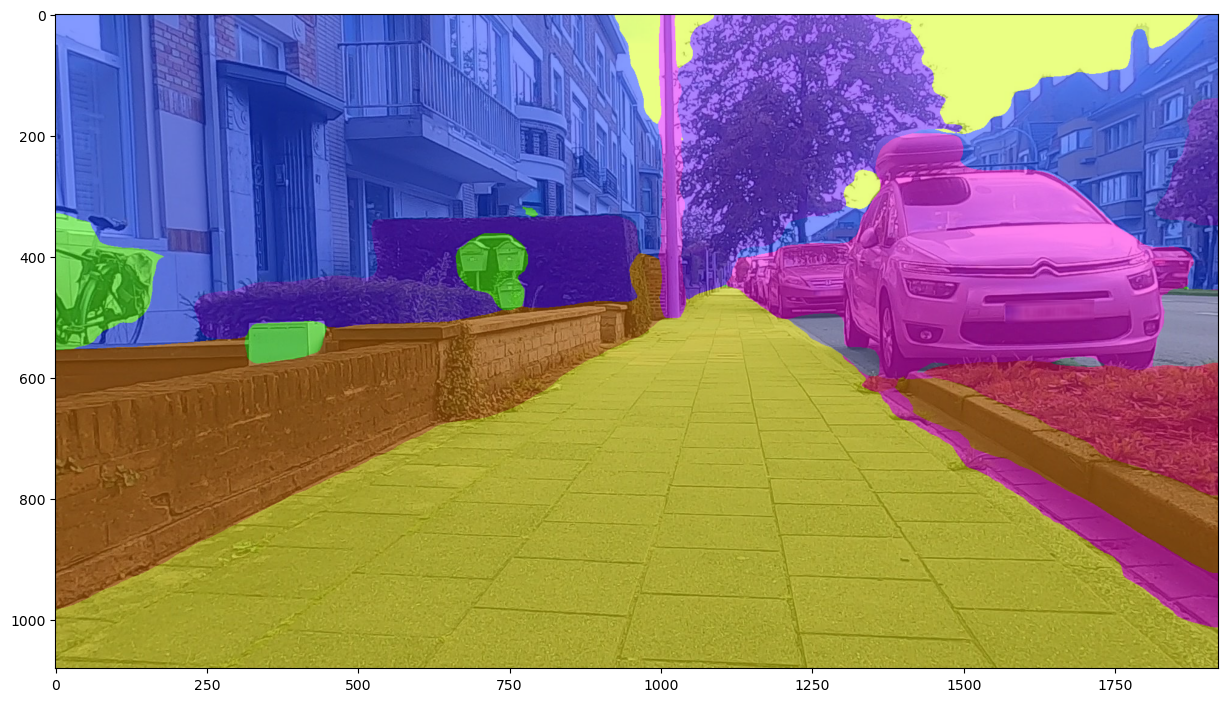

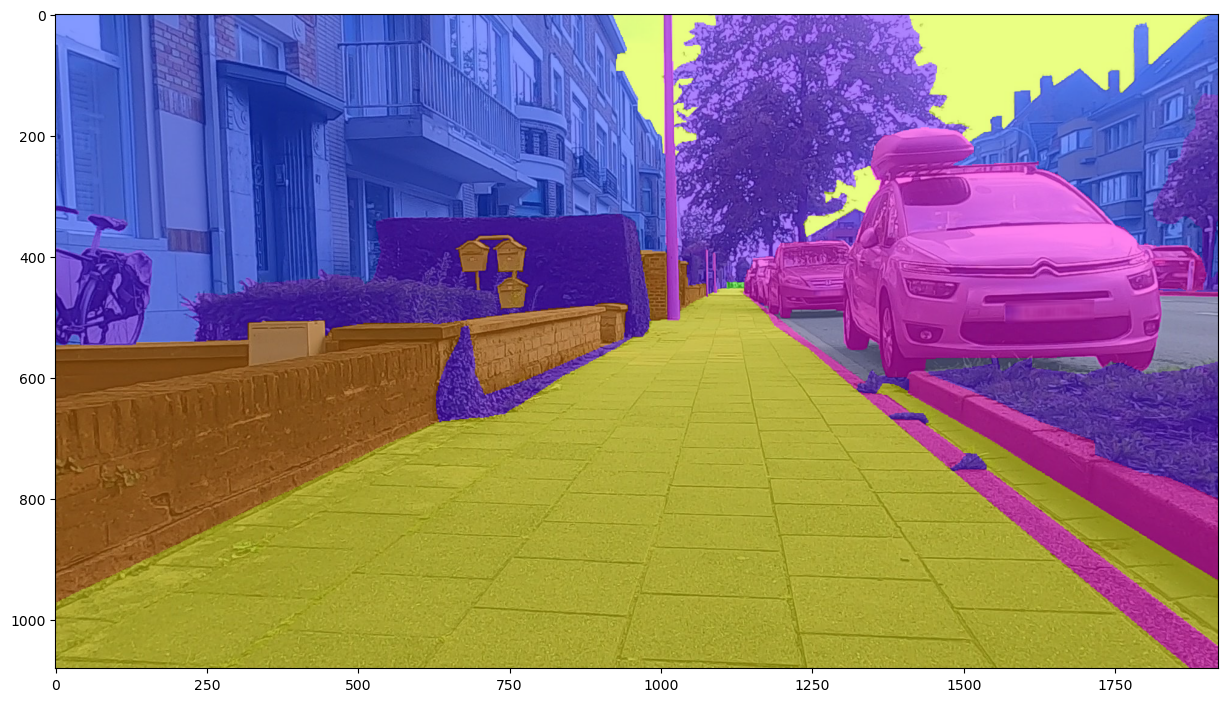

In [144]:
inference(finetuned_model, batch, processor)

In [58]:
def iou(mask1, mask2):
    mask1_area = torch.count_nonzero(mask1)
    mask2_area = torch.count_nonzero(mask2)
    intersection = torch.count_nonzero(torch.logical_and(mask1, mask2))
    iou = intersection / (mask1_area + mask2_area - intersection)
    return iou.item()

def get_ious(pred, truth):
    uniques = truth.unique()
    ious = {}
    for i in uniques:
        ious[i.item()] = iou(pred == i, truth == i)
    ious["mean"] = np.mean(list(ious.values()))
    return ious

In [51]:
ious = get_ious(predicted_segmentation_maps[1], torch.tensor(ground_truth_segmentation_maps[1]).to(device))

{1: 0.02679680474102497,
 2: 0.03902009129524231,
 4: 0.1206941157579422,
 5: 0.0,
 7: 0.0,
 10: 0.0,
 18: 0.08987408876419067,
 21: 0.0,
 25: 0.0,
 28: 0.2208966612815857,
 30: 0.2107846587896347,
 33: 0.014654353260993958,
 'mean': 0.06022673115755121}

In [59]:
eval_dataloader = DataLoader(test_ds, batch_size = 1, shuffle=False, collate_fn=partial(collate_fn_custom, processor = processor))

In [119]:
def eval_model2(modelName, modelType = Mask2FormerForUniversalSegmentation):
    if isinstance(modelName, str):
        model = modelType.from_pretrained(modelName).to(device)
    else:
        model = modelName
    resultlist = []
    for x in tqdm(eval_dataloader):
        img = x["pixel_values"]
        with torch.no_grad():
            output = model(img.to(device))

        original_image = x["original_images"][0]
        target_size = (original_image.shape[0], original_image.shape[1])
        pred = processor.post_process_semantic_segmentation(output, target_sizes = [target_size])[0]
        truth = x["original_segmentation_maps"][0]
        ious = get_ious(pred, torch.tensor(truth).to(device))
        resultlist.append(ious)
    ioudf = pd.DataFrame(resultlist)
    ioudf = pd.concat([ioudf["mean"], ioudf.drop("mean", axis=1).sort_index(axis=1)], axis=1)
    ioudf = ioudf.rename(columns=id2label)
    return ioudf


In [120]:
results_two_epochs = eval_model2("mask2former_finetuned_segments-sidewalk-semantic_2epochs")
results_twenty_epochs = eval_model2("mask2former_finetuned_segments-sidewalk-semantic_20epochs")
print(results_two_epochs["mean"].mean(), results_twenty_epochs["mean"].mean())

100%|██████████| 200/200 [01:11<00:00,  2.78it/s]

0.4659591518931731 0.539970218922894


In [126]:
from transformers import MaskFormerForInstanceSegmentation

model2 = "facebook/maskformer-swin-base-ade"
processor, model = load_model(model2, id2label = id2label, modelType = MaskFormerForInstanceSegmentation)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\dario\anaconda3\envs\dlvc\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:401: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
c:\Users\dario\anaconda3\envs\dlvc\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:408: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([36, 256]) in t

In [128]:
# finetune the maskformer model
train_dataloader, test_dataloader = create_batch(train_ds, test_ds, 2, processor)
n_epochs = 5
finetuned_model = train_model(model.to(device), train_dataloader, test_dataloader, processor, device, epochs = n_epochs)
finetuned_model.save_pretrained(f"maskformer_finetuned_{name.replace('/','-')}_{n_epochs}epochs")

Epoch: 0


  0%|          | 1/400 [01:05<7:17:41, 65.82s/it]


Loss: 1.8992722034454346


  0%|          | 1/400 [03:09<21:01:13, 189.66s/it]


KeyboardInterrupt: 